In [22]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [23]:
data_dir = './archive'

In [24]:
# Configuración del dataset
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")  # Convertimos a escala de grises
        if self.transform:
            image = self.transform(image)
        return image, label

In [25]:
# Función para cargar las imágenes y etiquetas
def load_data(data_dir):
    file_paths = []
    labels = []
    class_mapping = {
        "decks/cracked": 0,
        "decks/non-cracked": 1,
        "pavements/cracked": 2,
        "pavements/non-cracked": 3,
        "walls/cracked": 4,
        "walls/non-cracked": 5,
    }

    for label, idx in class_mapping.items():
        folder = os.path.join(data_dir, label)
        if os.path.exists(folder):  # Verificar que la carpeta exista
            for file in os.listdir(folder):
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):  # Verificar que es un archivo válido
                    file_paths.append(file_path)
                    labels.append(idx)

    return file_paths, labels
file_paths, labels = load_data(data_dir)


In [26]:
# Entrenamiento y prueba
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=26, stratify=labels
)
# Entrenamiento y validación
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=26, stratify=train_labels
)

In [27]:
# Transformaciones y DataLoaders
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# Definición del modelo
class ConvNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.dropout = nn.Dropout(dropout)  #dropout dinamico
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [29]:
# Configuración de hiperparámetros
params = {
    'dropout': 0.2,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'batch_size': 64,
    'epochs': 10,
    'patience': 3,
}

In [31]:
def initialize_model(params):
    model = ConvNet(dropout=params['dropout'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    return model, criterion, optimizer


In [17]:
model, criterion, optimizer = initialize_model(params)

In [32]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


In [33]:
def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    val_loss /= len(dataloader)
    report = classification_report(y_true, y_pred, output_dict=True)
    val_accuracy = report['accuracy']
    val_f1 = report['weighted avg']['f1-score']
    return val_loss, val_accuracy, val_f1


In [36]:
# Configuración de early stopping
patience = params['patience']
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(params['epochs']):
    # Entrenamiento
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    # Validación
    val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion)
    # Imprimir métricas
    print(f"Epoch {epoch + 1}/{params['epochs']} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1-Score: {val_f1:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No hay mejora en la pérdida de validación por {epochs_no_improve} época(s).")

    if epochs_no_improve >= patience:
        print("Early stopping activado. Entrenamiento detenido.")
        break


Epoch 1/10 - Train Loss: 0.9498, Val Loss: 0.9685, Val Accuracy: 0.5365, Val F1-Score: 0.5182
Guardando el mejor modelo con pérdida de validación 0.9685
Epoch 2/10 - Train Loss: 0.9379, Val Loss: 0.9139, Val Accuracy: 0.5626, Val F1-Score: 0.5546
Guardando el mejor modelo con pérdida de validación 0.9139
Epoch 3/10 - Train Loss: 0.8994, Val Loss: 0.8838, Val Accuracy: 0.5785, Val F1-Score: 0.5712
Guardando el mejor modelo con pérdida de validación 0.8838
Epoch 4/10 - Train Loss: 0.8663, Val Loss: 0.8934, Val Accuracy: 0.5833, Val F1-Score: 0.5764
No hay mejora en la pérdida de validación por 1 época(s).
Epoch 5/10 - Train Loss: 0.8561, Val Loss: 0.8516, Val Accuracy: 0.5862, Val F1-Score: 0.5736
Guardando el mejor modelo con pérdida de validación 0.8516
Epoch 6/10 - Train Loss: 0.8305, Val Loss: 0.8359, Val Accuracy: 0.5980, Val F1-Score: 0.5920
Guardando el mejor modelo con pérdida de validación 0.8359
Epoch 7/10 - Train Loss: 0.8131, Val Loss: 0.8083, Val Accuracy: 0.6124, Val F1-Sco

In [38]:
# Evaluación en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_loss /= len(test_loader)
report = classification_report(y_true, y_pred, target_names=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])

print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:\n", report)

C:\Users\elena\AppData\Local\Temp\ipykernel_17824\4110677643.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.7848
Classification Report:
                        precision    recall  f1-score   support

        decks/cracked       0.66      0.35      0.46       381
    decks/non-cracked       0.57      0.78      0.66       412
    pavements/cracked       0.72      0.69      0.70       522
pavements/non-cracked       0.74      0.74      0.74       524
        walls/cracked       0.55      0.51      0.53       770
    walls/non-cracked       0.57      0.65      0.61       783

             accuracy                           0.62      3392
            macro avg       0.64      0.62      0.62      3392
         weighted avg       0.63      0.62      0.62      3392



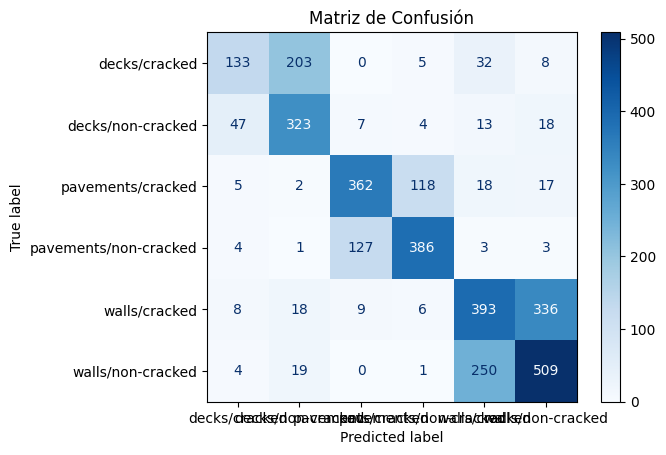

In [39]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [1]:
model.load_state_dict(torch.load('best_model.pth'))

NameError: name 'model' is not defined